# DC2, Template Generation, Image Difference, Sensor Edge Mask

Author: Shu Liu
Kernel: desc-stack-weekly-latest
Date: 02-29-2024

This notebook shows how to generate a template image for a DC2 science image. With a template and a science image, we can perform image difference. It also discusses the relationship between the position of non-saturation artifacts and the sensor edge mask.

## Get Image

In [1]:
from lsst.daf.butler import Butler
import pandas as pd

# LSST Science Pipeline using butler to read data
# repo and input collection tell butler where to search the data
repo = "/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo"
input_collection="u/descdm/coadds_Y1_4638"
butler = Butler(repo, writeable=True)

In [6]:
"""
def find_calexp(butler, input_collection, tract, patch, band):
    # find calexp id, calexps are used as science iamges
    calexp_DatasetRefs = sorted(list(set(
    butler.registry.queryDatasets(
        "calexp",
        collections = input_collection,
        where=f"instrument='LSSTCam-imSim' AND skymap='DC2' AND tract={tract} AND patch={patch} AND band='{band}'",
    ))))
    return calexp_DatasetRefs
"""

# These information will be used to obtrain images.
# They are called dimensions.
# More information can be obtained using the find_calexp function defined above

visit = int(211472)
detector = int(2)
band = str('i')
instrument = str('LSSTCam-imSim')
physical_filter = str('i_sim_1.4')
visit_system = int(1)

tract = int(4638)
patch = int(19)

# science id
science_id = {'visit': visit, 'detector': detector, 'band': band,
              'instrument': instrument, 'physical_filter': physical_filter,
              'visit_system': visit_system}

In [42]:
# Here are some other data ids can be used for testing
some_other_ids_for_test = pd.DataFrame({'patch': [22, 26], 'visit': [204559, 204516], 'detector': [9, 6],
                                       'band': ['i', 'i'], 'instrument': ['LSSTCam-imSim', 'LSSTCam-imSim'],
                                       'physical_filter': ['i_sim_1.4', 'i_sim_1.4'], 'tract': [4638, 4638]})

In [8]:
# get science image
science = butler.get("calexp", science_id, collections=input_collection)

Let's build a template image for a science image

In [9]:
from lsst.ip.diffim import GetTemplateConfig, GetTemplateTask

# patch_1d_to_2d, patch_2d_to_1d are just utility functions used to check the given patch is valid
def patch_1d_to_2d(patch):
    r = patch // 7
    c = patch % 7
    return r, c

def patch_2d_to_1d(r, c):
    patch = 7 * r + c
    return patch

def get_neighboring_patches(patch):
    # get neighboring patches to fully cover the region of a science image
    """
    00 01 02 03 04 05 06

    07 08 09 10 11 12 13

    14 15 16 17 18 19 20 

    21 22 23 24 25 26 27

    28 29 30 31 32 33 34

    35 36 37 38 39 40 41

    42 43 44 45 46 47 48"""
    
    if patch < 0 or patch > 48:
        return None
    patch_list = []
    r, c = patch_1d_to_2d(patch)
    for dr in (-2, -1, 0, 1, 2):
        for dc in (-2, -1, 0, 1, 2):
            if 0 <= r+dr <= 6 and 0 <= c+dc <= 6:
                patch_list.append(patch_2d_to_1d(r+dr, c+dc))
    patch_list.sort()
    return tuple(patch_list)

def get_template_for_science(science, butler, input_collection, tract, patch, band):
    # Initialize config and task objects
    get_template_task_config = GetTemplateConfig()
    get_template_task = GetTemplateTask(config=get_template_task_config)
    # Images used for building template are defined in 7*7 grids
    # Each grid is called a patch, the whole 7*7 region is called a tract
    # Get neighbouring patches of the science image
    patches = get_neighboring_patches(patch)
    # Get images for building a coadd
    coadd_exposure_deferred_dataset_handles = butler.registry.queryDatasets(
    "deepCoadd",
    collections=input_collection,
    where=f"instrument='LSSTCam-imSim' AND skymap='DC2' AND tract={tract} AND patch IN {patches} AND band='{band}'",
)
    coadd_exposures = [butler.get(dR) for dR in coadd_exposure_deferred_dataset_handles]
    coadd_data_ids = [{"tract": tract, "patch": p, "band": band} for p in patches]
    # Build coadd
    deep_coadd_template = get_template_task.run(coaddExposures=coadd_exposures,
                                            bbox=science.getBBox(),
                                            wcs=science.getWcs(),
                                            dataIds=coadd_data_ids)
    del coadd_exposures
    return deep_coadd_template

In [10]:
template_struct = get_template_for_science(science, butler, input_collection, tract, patch, band)
template = template_struct.template

In [11]:
import lsst.afw.image as afwImage

# we can directly save and read images to disc
template.writeFits('./template.fits')
science.writeFits('./science.fits')

template = afwImage.ExposureF('./template.fits')
science = afwImage.ExposureF('./science.fits')

Now we have both template image and scinece image. Let us visualize them.

In [12]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

Text(0.5, 1.0, 'science')

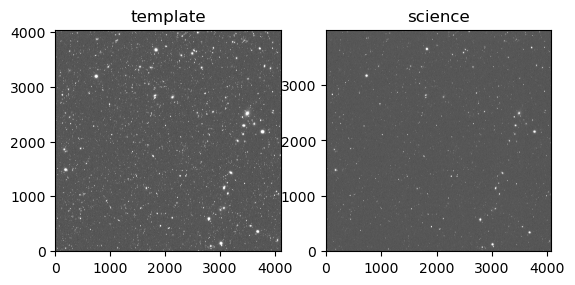

In [13]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(interval(template.getImage().array), cmap='gray', origin='lower')
ax[0].set_title('template')
ax[1].imshow(interval(science.getImage().array), cmap='gray', origin='lower')
ax[1].set_title('science')

We can also plot the variance plane

Text(0.5, 1.0, 'science')

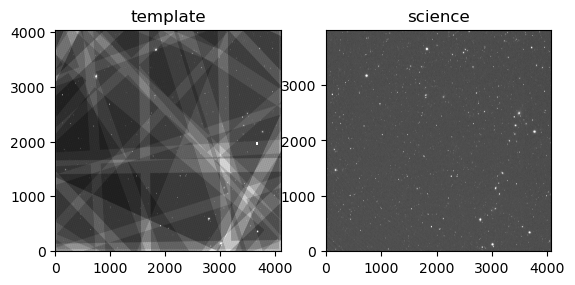

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(interval(template.getVariance().array), cmap='gray', origin='lower')
ax[0].set_title('template')
ax[1].imshow(interval(science.getVariance().array), cmap='gray', origin='lower')
ax[1].set_title('science')

## Image Difference

In [15]:
from lsst.ip.diffim import subtractImages
from lsst.ip.diffim import AlardLuptonSubtractTask
from lsst.ip.diffim import DetectAndMeasureConfig, DetectAndMeasureTask

def subtract(template, science, catalog, spatial_order=1, convolution_mode="convolveTemplate"):
    subtract_config = subtractImages.AlardLuptonSubtractTask.ConfigClass()
    subtract_config.makeKernel.kernel.active.spatialKernelOrder = spatial_order
    subtract_config.mode = convolution_mode
    subtraction_task = AlardLuptonSubtractTask(config=subtract_config)
    subtraction = subtraction_task.run(template=template, science=science, sources=catalog)
    _ = subtraction.difference.mask.addMaskPlane("STREAK")
    return subtraction, subtraction_task

def detect(science, subtraction):
    # Run detection on subtraction
    detect_and_measure_config = DetectAndMeasureConfig()
    detect_and_measure_task = DetectAndMeasureTask(config=detect_and_measure_config)

    detect_and_measure = detect_and_measure_task.run(science,
                                                     subtraction.matchedTemplate,
                                                     subtraction.difference)

    return detect_and_measure, detect_and_measure_task

To perform image difference, we need a catalog of stars measured from the science image.

In [16]:
src = butler.get('src', dataId=science_id, collections=input_collection)

In [17]:
# src table can also be transformed to an astropy table
# src.asAstropy()

In [18]:
subtraction, _ = subtract(template, science, src, spatial_order=1, convolution_mode="convolveTemplate")

In [19]:
detection, _ = detect(science, subtraction)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-8.0.0/Linux64/meas_extensions_trailedSources/g3ddfee87b4+08f09657f2/python/lsst/meas/extensions/trailedSources/NaivePlugin.py:393: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(Ixx - 2.0*Iyy)


In [20]:
# The detection provides us two data products, the difference image and the detected sources (diaSrc).
difference = detection.subtractedMeasuredExposure
diaSrc = detection.diaSources.asAstropy().to_pandas()

In [21]:
# save them to disc
difference.writeFits('./difference.fits')
diaSrc.to_csv('./diaSrc.csv', index=False)

## Analysis of sensor edge mask

In [22]:
template = afwImage.ExposureF('./template.fits')
diaSrc = pd.read_csv('./diaSrc.csv')

Let us plot the non-saturation artifacts on top of the sensor edge mask of the template image. The non-saturation artifacts can be obtained by filtering with the saturation flags. In this analysis, we assume all detections are artifacts.

In [23]:
def remove_src_with_flags(src_df, flag_list=None):
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) == 0).to_numpy()
    return src_df[keep_id].copy().reset_index(drop=True)

nonsat =  remove_src_with_flags(diaSrc, flag_list=['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter'])

In [24]:
# Mask information are encoded as bits
# We need to decode it
import numpy as np

def translateMask(mask):
    NUM_BITS = 19
    TO_AND = 2**np.arange(NUM_BITS).reshape([1, NUM_BITS])

    x = mask.array 
    xshape = list(x.shape)
    x = x.reshape([-1, 1])

    unpck = (x & TO_AND).astype(bool).reshape(xshape + [NUM_BITS])  # ditched the astype(int)

    codes = mask.getMaskPlaneDict()
    mask_dict = {} 
    for k, v in codes.items(): 
        mask_dict[k] = unpck[:, :, v]
    return mask_dict

template_mask = translateMask(template.getMask())

In [25]:
# There are different types of masks
template_mask.keys()

dict_keys(['BAD', 'CLIPPED', 'CR', 'CROSSTALK', 'DETECTED', 'DETECTED_NEGATIVE', 'EDGE', 'INEXACT_PSF', 'INJECTED', 'INJECTED_TEMPLATE', 'INTRP', 'NOT_DEBLENDED', 'NO_DATA', 'REJECTED', 'SAT', 'SENSOR_EDGE', 'STREAK', 'SUSPECT', 'UNMASKEDNAN'])

In [26]:
import lsst.geom as geom
from matplotlib.patches import Circle

def radec2xy(ra, dec, wcs):
    """This function converts radec to physics xy.
       ra:        ra in degree
       dec:       dec in degree
       wcs:       wcs of an exposure
       
       Returns:
       xy coordinates
    """
    radec = geom.SpherePoint(ra * geom.degrees, dec * geom.degrees)
    xy = geom.PointI(wcs.skyToPixel(radec))
    return xy.getX(), xy.getY()

def xy2radec(x, y, wcs):
    radec = geom.SpherePoint(wcs.pixelToSky(x, y))
    ra = radec.getRa().asDegrees()
    dec = radec.getDec().asDegrees()
    return ra, dec

def add_circular_patch_from_radec(ax, source_table, bbox, wcs, color, alpha=1, size=50):
    # source_table must contains a column of ra and a column of dec
    # ra and dec are in degrees
    beginX, beginY = bbox.beginX, bbox.beginY
    for i, row in source_table.iterrows():
        ra, dec = row['ra'], row['dec']
        # physics coordinate has an offset to the pixel coordinate
        phys_x, phys_y = radec2xy(ra, dec, wcs)
        dx, dy = phys_x - beginX, phys_y - beginY
        circ = Circle((dx, dy), size, color=color, fill=False, alpha=alpha)
        ax.add_patch(circ) 

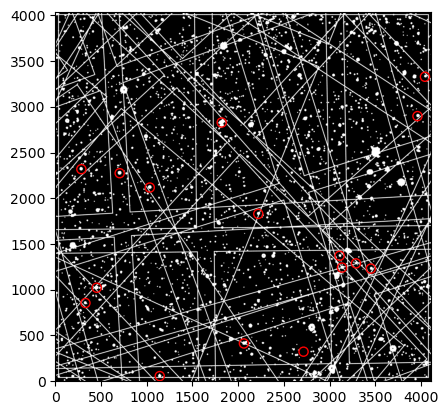

In [27]:
# In this analysis, we only focus on the sensor edge mask and the detected mask
fig, ax = plt.subplots(1, 1)
mask = np.logical_or(template_mask['SENSOR_EDGE'], template_mask['DETECTED']).astype(int)
ax.imshow(mask, cmap='gray', origin='lower')

# add non-saturation artifacts on top of the mask
ra = nonsat.coord_ra.map(np.rad2deg)
dec = nonsat.coord_dec.map(np.rad2deg)
sky_coords = pd.DataFrame({'ra': ra, 'dec': dec})
add_circular_patch_from_radec(ax, sky_coords, template.getBBox(), template.getWcs(), 'r')

Most of these artifacts are from bright stars. It seems that these artifacts are close to the sensor edge. Let us generate some random points for comparision.

In [28]:
np.random.seed(1)
# generate random row index and column index
random_r = np.random.randint(0, mask.shape[0]-1, size=len(nonsat))
random_c = np.random.randint(0, mask.shape[1]-1, size=len(nonsat))
random_rc = list(zip(random_r, random_c))
# convert r and c into skycoordinates
# get bounding box
bbox = template.getBBox()
# get beginX and beginY of physical coordinates
begin_x, begin_y = bbox.beginX, bbox.beginY

random_skycoords = []
for rc in random_rc:
    r, c = rc[0], rc[1]
    pixel_x, pixel_y = begin_x + c, begin_y + r
    ra, dec = xy2radec(pixel_x, pixel_y, template.getWcs())
    random_skycoords.append([ra, dec])
random_skycoords = pd.DataFrame(random_skycoords, columns=['ra', 'dec'])

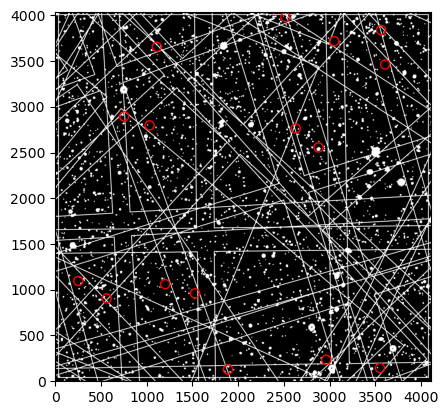

In [29]:
# In this analysis, we only focus on the sensor edge mask and the detected mask
fig, ax = plt.subplots(1, 1)
ax.imshow(mask, cmap='gray', origin='lower')

# add random position on top of the mask
add_circular_patch_from_radec(ax, random_skycoords, template.getBBox(), template.getWcs(), 'r')

Even random points are close to sensor edge.

Let us analyze this problem quantitatively by calculating the distance of each points to the sensor edge.

In [30]:
from collections import deque

def valid_rc(r, c, max_r, max_c):
    # This function check whether the row index and column index are valid
    if 0 <= r <= max_r and 0 <= c <= max_c:
        return True
    else:
        return False

def get_nearest_distance_to_sensor_edge(r, c, sensor_edge):
    """
    This funciton measure the nearest distance of a point to the sensor edge.
    The algorithm starts with a given point, then it grows a sqaure from the given point.
    In each iteration, the grow the half width of the square by one pixel.
    The iteration stops when the boundary of the square reach the sensor edge.
    The distance is the total number of iteration - 1.
    Example:
                                   x x x x x  
                        x x x      x x x x x 
    square       x  ->  x x x  ->  x x x x x
                        x x x      x x x x x  
                                   x x x x x 
    distance     0        1            2       
    
    Parameters:
    r: row index
    c: column index
    """
    
    sensor_edge = sensor_edge.copy()
    sensor_edge = sensor_edge.astype(int)
    max_r, max_c = sensor_edge.shape[0]-1, sensor_edge.shape[1]-1
    # delta indexes to the neighboring points
    delta_step = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    # create a queue to store the results
    queue = deque([(r, c)])
    # memorize visited points
    added = {(r, c)}
    # initialize the distance
    distance = -1
    # use breadth first search method
    while len(queue) > 0:
        distance += 1
        length = len(queue)
        for i in range(length):
            # pop out the points from the current boundary
            cur_r, cur_c = queue.popleft()
            if sensor_edge[cur_r][cur_c] == 1:
                return distance
            for delta in delta_step:
                dr, dc = delta[0], delta[1]
                next_r, next_c = cur_r + dr, cur_c + dc
                if valid_rc(next_r, next_c, max_r, max_c) and (next_r, next_c) not in added:
                    queue.append((next_r, next_c))
                    added.add((next_r, next_c))
    return distance

In [31]:
sensor_edge = template_mask['SENSOR_EDGE'].astype('int')

In [32]:
artifact_distance = np.zeros(len(nonsat))
for i, source in nonsat.iterrows():
    pixel_x, pixel_y = source['base_NaiveCentroid_x'], source['base_NaiveCentroid_y']
    r, c = int(pixel_y - begin_y), int(pixel_x - begin_x)
    distance = get_nearest_distance_to_sensor_edge(r, c, sensor_edge)
    artifact_distance[i] = distance

In [33]:
random_distance = np.zeros(len(nonsat))
for i, rc in enumerate(random_rc):
    r, c = rc[0], rc[1]
    distance = get_nearest_distance_to_sensor_edge(r, c, sensor_edge)
    random_distance[i] = distance

In [34]:
print('mean distance of artifacts %.2f.' % artifact_distance.mean())
print('mean distance of random points %.2f.' % random_distance.mean())

mean distance of artifacts 22.25.
mean distance of random points 25.00.


The mean distance from random points are close to the mean distance from non-saturation artifacts.

In [35]:
# probability of a random point to occur at the sensor edge.
sensor_edge.sum() / (sensor_edge.shape[0] * sensor_edge.shape[1])

0.11395192048387719

In [36]:
random_distance

array([39., 35.,  5., 50.,  7.,  8.,  8., 33.,  3., 25., 29.,  6.,  5.,
       41., 73., 33.])

Use Kolmogorov-Smirnov test to compare the distances

In [37]:
from scipy import stats

In [38]:
alpha = 0.05
statistic, p_value = stats.ks_2samp(artifact_distance, random_distance)

In [39]:
print('p value is %.3f' %p_value)
print('From the same distribution: %s' %str(p_value > alpha))

p value is 0.215
From the same distribution: True
